<a href="https://colab.research.google.com/github/y001003/dacon/blob/main/used_car/%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%A4%91%EA%B3%A0%EC%B0%A8_%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이콘 중고차 가격예측 모형

나이지리아에 판매된 중고차의 데이터를 이용하여, test 데이터의 중고차 가격을 예측하는 모형을 만들어 본다.


## 1. 데이터 및 라이브러리 불러오기

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/project/dacon_car/train.csv의 사본')
test = pd.read_csv('/content/drive/MyDrive/project/dacon_car/test.csv의 사본')
sample = pd.read_csv('/content/drive/MyDrive/project/dacon_car/sample_submission.csv')
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
train_df


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
1010,1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
1011,1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
1012,1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
1013,1013,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


## 2. Data Preprocessing

### 2_1. 데이터 컬럼 설명

    id : 샘플 아이디
    title : 제조사 모델명
    odometer : 주행 거리
    location : 판매처(나이지리아 도시)
    isimported : 현지 사용 여부
    engine : 엔진 종류
    transmission : 트랜스미션 종류
    fuel : 연료 종류
    paint : 페인트 색상
    year : 제조년도
    target : 자동차 가격


### 2_2. 데이터 결측치 확인

In [4]:
# 결측치 확인 결과, 결측치 X
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


### 2_3. 컬럼 선택


In [5]:
train_df = train_df.drop(columns='id')
test_df = test_df.drop(columns='id')

## 3. EDA

In [6]:
train_df.head()

,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [7]:
sns.set(rc={'figure.figsize':(15, 5)})

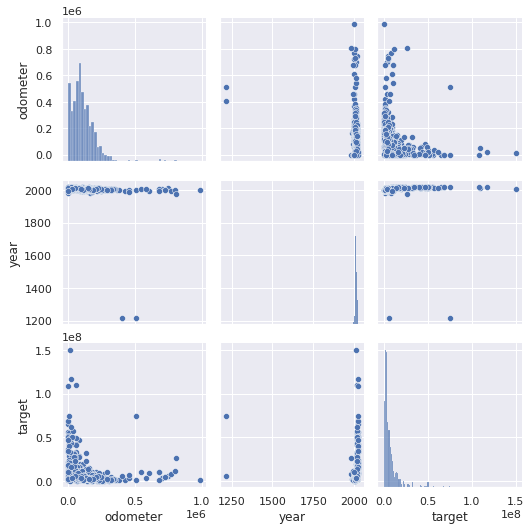

In [8]:
sns.pairplot(train_df)

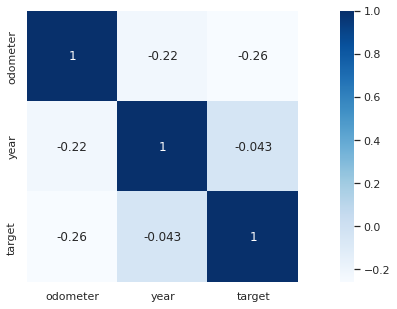

In [9]:
sns.heatmap(data=train_df.corr(),square=True,cmap="Blues",annot=True)

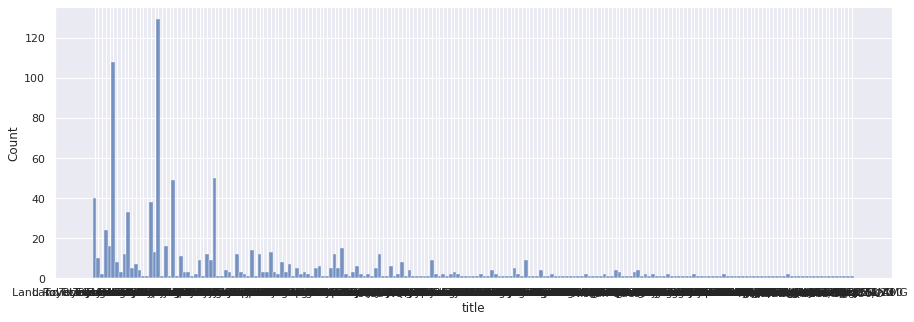

In [10]:
sns.histplot(data=train_df,x='title')

### 3_2. 이상치 제거

In [11]:
# 사용여부 New이면서 주행거리수가 높은 이상치 제거
train_df[(train_df['isimported'] == 'New ') & (train_df['odometer'] > 20000)]

,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
316,Honda Civic,24997,Abuja,New,4-cylinder(I4),automatic,petrol,White,2018,8665000
909,Toyota Sienna,82589,Lagos,New,6-cylinder(V6),automatic,petrol,Black,2011,5185000


In [12]:
train_df[train_df['engine'].isin(train_df['engine'].value_counts()[train_df['engine'].value_counts()>50].index)]

,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...
1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
1013,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


In [13]:
train_df = train_df[~(train_df['year'] < 1980)]

In [14]:
X =train_df.iloc[:,:-1]
y = train_df.iloc[:,-1:]
X.shape, y.shape

((1013, 9), (1013, 1))

## 4. Training

In [15]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from lightgbm.sklearn import LGBMRegressor

###4_1. Encoding

#### 4_1_1 ordinal encoding

In [16]:
# no Encoding
# OrdinalEncoder
encoder = OrdinalEncoder()
train_encoded = encoder.fit_transform(X)
train_encoded

array([[178.,  80.,   8., ...,   1.,  51.,  26.],
       [175.,   1.,   7., ...,   1.,   6.,  29.],
       [ 70., 390.,   7., ...,   1.,  51.,  22.],
       ...,
       [167., 493.,   2., ...,   1.,   6.,  21.],
       [ 79., 709.,   7., ...,   1.,  29.,  23.],
       [ 20.,   0.,   7., ...,   0.,  73.,   8.]])

#### 4_1_2 one hot encoding 

In [17]:
encoder2 = OneHotEncoder()
train_encoded = encoder2.fit_transform(X)
train_encoded

<1013x1320 sparse matrix of type '<class 'numpy.float64'>'
	with 9117 stored elements in Compressed Sparse Row format>

#### 4_1_3 one hot encoding & label encoding

In [18]:
X1 = X.copy()
X1['title'] = X1['title'].str.extract('([A-Za-z]+)', expand=False)
X1

,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,Toyota,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016
1,Toyota,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019
2,Land,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012
3,Lexus,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007
4,Toyota,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010
...,...,...,...,...,...,...,...,...,...
1010,Toyota,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014
1011,Toyota,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011
1012,Toyota,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011
1013,Lexus,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013


In [19]:
train_df['engine'].value_counts()[train_df['engine'].value_counts()>50].index

Index(['4-cylinder(I4)', '6-cylinder(V6)', '6-cylinder(I6)'], dtype='object')

In [20]:
# title-onehot 10개 이하 지우고 , location-onehot 4개 이하 지우고, isimported-onehot, engine-ordinal, transmission-onehot, fuel-onehot, paint column 삭제
X1.title.value_counts(),X1.location.value_counts(),X1.isimported.value_counts(),X1.engine.value_counts(),X1.transmission.value_counts(),X1.fuel.value_counts(),X1.year.value_counts(),X1.paint.value_counts()

(Toyota        474
 Lexus         122
 Mercedes      104
 Honda          81
 Ford           36
 Nissan         24
 Hyundai        24
 Land           19
 Kia            15
 Volkswagen     13
 BMW            10
 Acura           9
 Mack            8
 Mazda           8
 Volvo           7
 Chevrolet       5
 Infiniti        5
 Mitsubishi      4
 DAF             4
 Man             4
 GAC             4
 Porsche         4
 Jaguar          3
 Peugeot         3
 Pontiac         3
 Scania          3
 MINI            2
 Isuzu           2
 Dodge           1
 GMC             1
 Iveco           1
 IVM             1
 IVECO           1
 Lincoln         1
 Rolls           1
 MAN             1
 Jeep            1
 ALPINA          1
 Bentley         1
 JMC             1
 Audi            1
 Name: title, dtype: int64, Lagos          790
 Abuja          146
 Ogun            26
 Lagos           23
 Lagos State     16
 other            4
 FCT              2
 Accra            1
 Abuja            1
 Abia State   

In [21]:
# title 10개 이상
title_con = list(X1['title'].value_counts()[X1['title'].value_counts()>=40].index)
# location-4개 이상
loc_con = list(X1['location'].value_counts()[X1['location'].value_counts()>=100].index)
# engine 49개 이상
engine_con = list(X1['engine'].value_counts()[X1['engine'].value_counts()>=49].index)

In [44]:
# title-onehot 10개 이하 지우고 , location-onehot 4개 이하 지우고, isimported-onehot, engine-onehot, transmission-onehot, fuel-onehot, paint column 삭제, odomete label encoding와 year label encoding 둘중 하나만 사용
# title onehot
X1_title = pd.get_dummies(X1['title'])[title_con]
# location onehot
X1_location = pd.get_dummies(X1['location'])[loc_con]
# isimported
X1_isimported = pd.get_dummies(X1['isimported'])
# engine
X1_engine = pd.get_dummies(X1['engine'])[engine_con]
# transmission
X1_transmission = pd.get_dummies(X1['transmission'])
# fuel
X1_fuel = pd.get_dummies(X1['fuel'])
X1_odometer = X1['odometer']
X1_year = X1['year']
X1_dataframes = [X1_title,X1_isimported,X1_location,X1_engine,X1_odometer,X1_year,y]

In [45]:
# 데이터 프레임 합치기
train_encoded = pd.concat(X1_dataframes,axis=1)

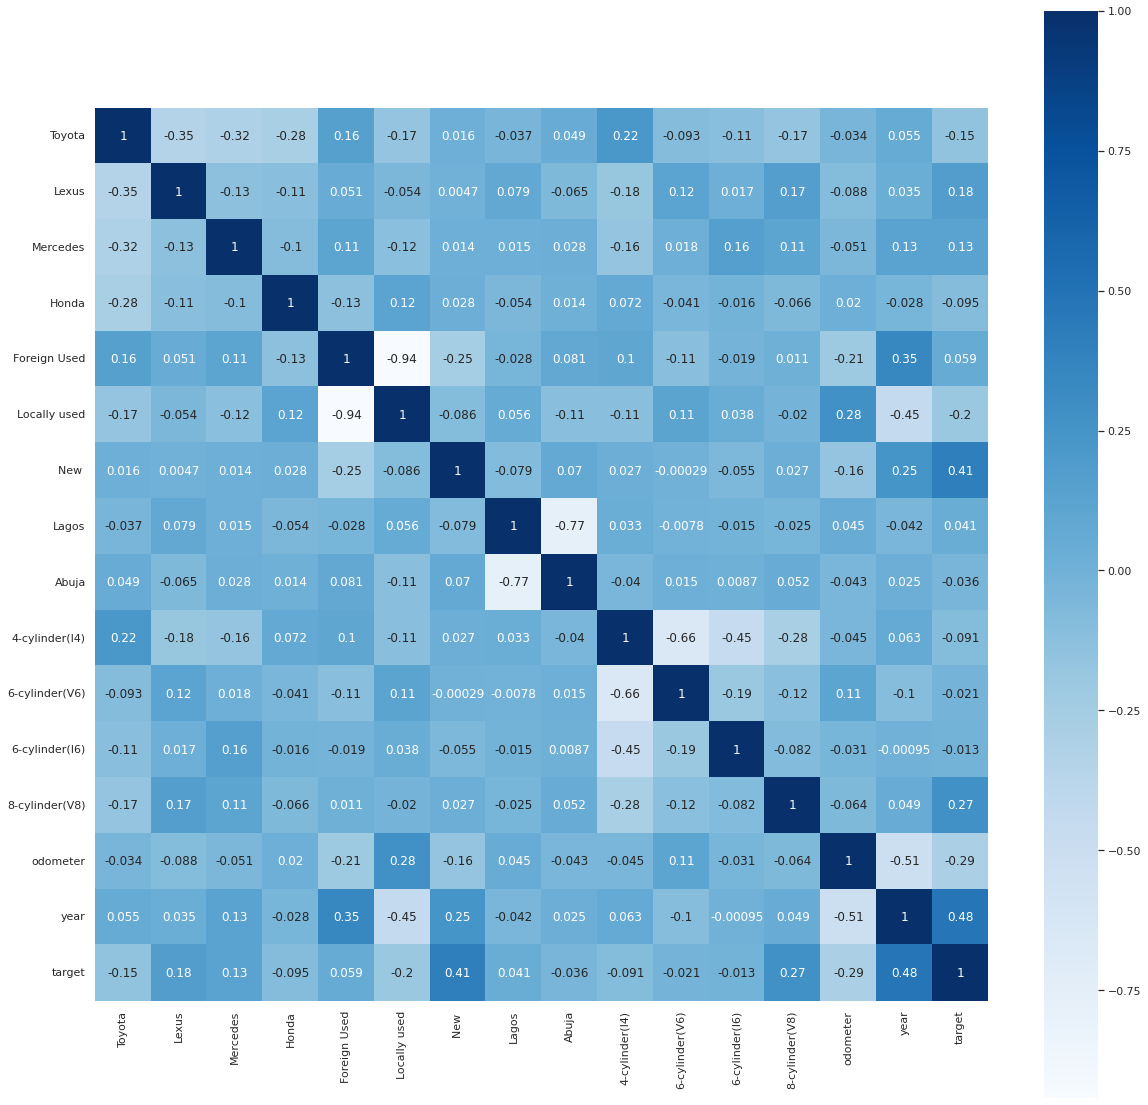

In [46]:
sns.set(rc={'figure.figsize':(15, 5)})
plt.figure(figsize=(20,20))
sns.heatmap(data=train_encoded.corr(),square=True,cmap="Blues",annot=True)

#### 4_1_4. 과적합 데이터 찾기

In [47]:
train_encoded

,Toyota,Lexus,Mercedes,Honda,Foreign Used,Locally used,New,Lagos,Abuja,4-cylinder(I4),6-cylinder(V6),6-cylinder(I6),8-cylinder(V8),odometer,year,target
0,1,0,0,0,1,0,0,0,0,1,0,0,0,18277,2016,13665000.0
1,1,0,0,0,0,0,1,1,0,1,0,0,0,10,2019,33015000.0
2,0,0,0,0,1,0,0,1,0,0,1,0,0,83091,2012,9915000.0
3,0,1,0,0,1,0,0,1,0,1,0,0,0,91524,2007,3815000.0
4,1,0,0,0,1,0,0,1,0,0,1,0,0,94177,2010,7385000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,1,0,0,0,1,0,0,1,0,1,0,0,0,46768,2014,5415000.0
1011,1,0,0,0,1,0,0,0,1,1,0,0,0,31600,2011,3615000.0
1012,1,0,0,0,1,0,0,0,1,1,0,0,0,96802,2011,3415000.0
1013,0,1,0,0,1,0,0,1,0,0,1,0,0,146275,2013,14315000.0


In [48]:
# new 새차인데 odometer 주행거리수가 많은 데이터 삭제
overfit1 = (train_encoded['New '] == 1 ) & (train_encoded['odometer'] > 9000 )
train_encoded = train_encoded[~overfit1]

In [49]:
# odometer 주행거리수 0인 데이터
overfit2 = (train_encoded['odometer'] == 0 )
train_encoded = train_encoded[~overfit2]

In [50]:
train_encoded.to_csv('/content/drive/MyDrive/project/dacon_car/train_encoded.csv')

In [51]:
train_encoded.head()

,Toyota,Lexus,Mercedes,Honda,Foreign Used,Locally used,New,Lagos,Abuja,4-cylinder(I4),6-cylinder(V6),6-cylinder(I6),8-cylinder(V8),odometer,year,target
0,1,0,0,0,1,0,0,0,0,1,0,0,0,18277,2016,13665000.0
1,1,0,0,0,0,0,1,1,0,1,0,0,0,10,2019,33015000.0
2,0,0,0,0,1,0,0,1,0,0,1,0,0,83091,2012,9915000.0
3,0,1,0,0,1,0,0,1,0,1,0,0,0,91524,2007,3815000.0
4,1,0,0,0,1,0,0,1,0,0,1,0,0,94177,2010,7385000.0


In [52]:
# train_encoded.sort_values(by=['target'],ascending=False) > 10000000

In [53]:
# train_encoded = train_encoded[~(train_encoded['target']>60000000)]

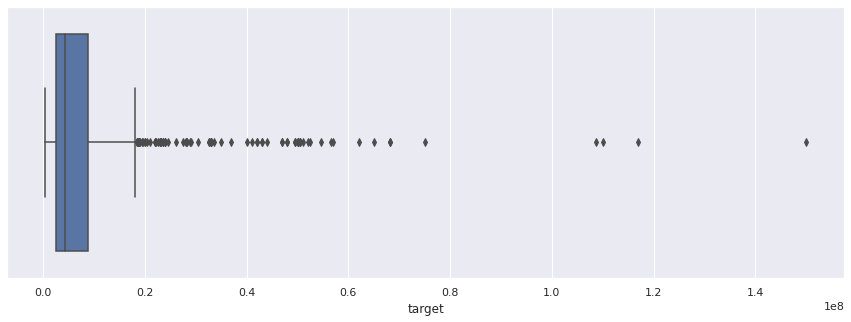

In [54]:
sns.boxplot(x ='target',  data = train_encoded)

plt.show()

In [55]:
y = train_encoded.iloc[:,-1:]
train_encoded = train_encoded.iloc[:,:-1]
train_encoded

,Toyota,Lexus,Mercedes,Honda,Foreign Used,Locally used,New,Lagos,Abuja,4-cylinder(I4),6-cylinder(V6),6-cylinder(I6),8-cylinder(V8),odometer,year
0,1,0,0,0,1,0,0,0,0,1,0,0,0,18277,2016
1,1,0,0,0,0,0,1,1,0,1,0,0,0,10,2019
2,0,0,0,0,1,0,0,1,0,0,1,0,0,83091,2012
3,0,1,0,0,1,0,0,1,0,1,0,0,0,91524,2007
4,1,0,0,0,1,0,0,1,0,0,1,0,0,94177,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0,0,0,0,0,1,0,1,0,0,1,0,0,809456,1980
1010,1,0,0,0,1,0,0,1,0,1,0,0,0,46768,2014
1011,1,0,0,0,1,0,0,0,1,1,0,0,0,31600,2011
1012,1,0,0,0,1,0,0,0,1,1,0,0,0,96802,2011


In [56]:
y

,target
0,13665000.0
1,33015000.0
2,9915000.0
3,3815000.0
4,7385000.0
...,...
1009,26015000.0
1010,5415000.0
1011,3615000.0
1012,3415000.0


### 4_2. Train_Test split

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_encoded,y,test_size=0.2, random_state=42)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((791, 15), (198, 15), (791, 1), (198, 1))

In [58]:
from sklearn.preprocessing import StandardScaler
# 표준정규분포로
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# X_test = scaler.transform(test_df)

### 4_3. Training

In [59]:
from sklearn.linear_model import LinearRegression# 1. Linear Regression
from sklearn.linear_model import Lasso# 2. Lasso
from sklearn.linear_model import Ridge# 3. Ridge
from xgboost.sklearn import XGBRegressor# 4. XGBoost
from lightgbm.sklearn import LGBMRegressor# 5. LightGBM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [60]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 7
params

{'boosting_type': 'gbdt',
 'learning_rate': 0.003,
 'max_depth': 7,
 'min_data': 50,
 'num_leaves': 10,
 'sub_feature': 0.5}

In [61]:
# training
reg = LinearRegression()
reg2 = Lasso()
reg3 = Ridge()
reg4 = XGBRegressor()
f = LGBMRegressor()

from sklearn.model_selection import GridSearchCV

parameters = {
    'num_leaves': [20,25,30],
    'max_depth': [6,7,8,9],
    'learning_rate' : [0.1,0.001,0.003]
    }
reg5 = GridSearchCV(f,parameters,cv=3,refit=True)


reg.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)
reg4.fit(X_train, y_train)
reg5.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_train2 = reg2.predict(X_train)
pred_train3 = reg3.predict(X_train)
pred_train4 = reg4.predict(X_train)
pred_train5 = reg5.predict(X_train)

pred_val = reg.predict(X_val)
pred_val2 = reg2.predict(X_val)
pred_val3 = reg3.predict(X_val)
pred_val4 = reg4.predict(X_val)
pred_val5 = reg5.predict(X_val)

mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)
mse_train2 = mean_squared_error(y_train, pred_train2)
mse_val2 = mean_squared_error(y_val, pred_val2)
mse_train3 = mean_squared_error(y_train, pred_train3)
mse_val3 = mean_squared_error(y_val, pred_val3)
mse_train4 = mean_squared_error(y_train, pred_train4)
mse_val4 = mean_squared_error(y_val, pred_val4)
mse_train5 = mean_squared_error(y_train, pred_train5)
mse_val5 = mean_squared_error(y_val, pred_val5)

mae_train = mean_absolute_error(y_train, pred_train)
mae_val = mean_absolute_error(y_val, pred_val)
mae_train2 = mean_absolute_error(y_train, pred_train2)
mae_val2 = mean_absolute_error(y_val, pred_val2)
mae_train3 = mean_absolute_error(y_train, pred_train3)
mae_val3 = mean_absolute_error(y_val, pred_val3)
mae_train4 = mean_absolute_error(y_train, pred_train4)
mae_val4 = mean_absolute_error(y_val, pred_val4)
mae_train5 = mean_absolute_error(y_train, pred_train5)
mae_val5 = mean_absolute_error(y_val, pred_val5)

rscore_train = r2_score(y_train, pred_train)
rscore_val = r2_score(y_val, pred_val)
rscore_train2 = r2_score(y_train, pred_train2)
rscore_val2 = r2_score(y_val, pred_val2)
rscore_train3 = r2_score(y_train, pred_train3)
rscore_val3 = r2_score(y_val, pred_val3)
rscore_train4 = r2_score(y_train, pred_train4)
rscore_val4 = r2_score(y_val, pred_val4)
rscore_train5 = r2_score(y_train, pred_train5)
rscore_val5 = r2_score(y_val, pred_val5)

print("1. Linear Regression\t, train/val = %.4f, %.4f" % (mse_train, mse_val))
print("2. Lasso Regression\t, train/val = %.4f, %.4f" % (mse_train2, mse_val2))
print("3. Ridge Regression\t, train/val = %.4f, %.4f" % (mse_train3, mse_val3))
print("4. XGBoost\t\t, train/val = %.4f, %.4f" % (mse_train4, mse_val4))
print("5. LightGBM\t\t, train/val = %.4f, %.4f" % (mse_train5, mse_val5))

print("1. Linear Regression\t, train/val = %.4f, %.4f" % (mae_train, mae_val))
print("2. Lasso Regression\t, train/val = %.4f, %.4f" % (mae_train2, mae_val2))
print("3. Ridge Regression\t, train/val = %.4f, %.4f" % (mae_train3, mae_val3))
print("4. XGBoost\t\t, train/val = %.4f, %.4f" % (mae_train4, mae_val4))
print("5. LightGBM\t\t, train/val = %.4f, %.4f" % (mae_train5, mae_val5))

print("1. Linear Regression\t, train/val = %.4f, %.4f" % (rscore_train, rscore_val))
print("2. Lasso Regression\t, train/val = %.4f, %.4f" % (rscore_train2, rscore_val2))
print("3. Ridge Regression\t, train/val = %.4f, %.4f" % (rscore_train3, rscore_val3))
print("4. XGBoost\t\t, train/val = %.4f, %.4f" % (rscore_train4, rscore_val4))
print("5. LightGBM\t\t, train/val = %.4f, %.4f" % (rscore_train5, rscore_val5))

[01:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

1. Linear Regression	, train/val = 100263866082055.8906, 47050312107499.5078
2. Lasso Regression	, train/val = 100256636749343.1875, 47111366012419.9531
3. Ridge Regression	, train/val = 100256970635193.6875, 47103500369532.5625
4. XGBoost		, train/val = 24407682667939.8320, 28692042425308.0391
5. LightGBM		, train/val = 49793933131469.3906, 26226742939233.4336
1. Linear Regression	, train/val = 5035070.3795, 4281818.9405
2. Lasso Regression	, train/val = 5037536.5063, 4290330.5288
3. Ridge Regression	, train/val = 5035888.0065, 4288572.3448
4. XGBoost		, train/val = 2540195.4776, 2734919.2841
5. LightGBM		, train/val = 3002586.6794, 2760678.6137
1. Linear Regression	, train/val = 0.3941, 0.5299
2. Lasso Regression	, train/val = 0.3941, 0.5293
3. Ridge Regression	, train/val = 0.3941, 0.5294
4. XGBoost		, train/val = 0.8525, 0.7133
5. LightGBM		, train/val = 0.6991, 0.7380


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [62]:
print(reg5.best_params_)
print(reg5.best_score_)
print(reg5.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 25}
0.3983755187251779
LGBMRegressor(max_depth=9, num_leaves=25)


In [63]:
from sklearn.metrics import mean_squared_error
reg5 = LGBMRegressor(learning_rate=0.1,max_depth=8,num_leaves=20)
reg5.fit(X_train, y_train)
pred_train5 = reg5.predict(X_train)
pred_val5 = reg5.predict(X_val)
mse_train5 = mean_squared_error(y_train, pred_train5)
mse_val5 = mean_squared_error(y_val, pred_val5)
print("5. LightGBM\t\t, train/val = %.4f, %.4f" % (mse_train5, mse_val5))
print("5. LightGBM\t\t, train/val = %.4f, %.4f" % (rscore_train5, rscore_val5))
reg5.best_score_

5. LightGBM		, train/val = 50149636682085.4844, 25785119791374.6719
5. LightGBM		, train/val = 0.6991, 0.7380


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


defaultdict(dict, {})

### 4_2 LightGBM 확인


In [42]:
reg5.feature_importances_,train_encoded.columns
pd.DataFrame([reg5.feature_importances_,train_encoded.columns]).T

,0,1
0,93,Toyota
1,22,Lexus
2,25,Mercedes
3,38,Honda
4,41,Foreign Used
5,0,Locally used
6,0,New
7,23,Lagos
8,7,Abuja
9,57,4-cylinder(I4)


## 5. Test(Prediction)

In [43]:
test_encoded = encoder.fit_transform(test_df)
pred_test = reg5.predict(test_encoded)

ValueError: ignored

In [ ]:
test_df.index

In [ ]:
pred_test

In [ ]:
id = pd.DataFrame({'id':test_df.index})
target = pd.DataFrame(pred_test)
target.rename(columns={0:'target'},inplace=True)
# pred_test
target

In [ ]:

submit = pd.concat([id, target],axis=1)
submit.set_index('id',inplace=True)

In [ ]:
submit.to_csv('/content/drive/MyDrive/project/dacon_car/submit1.csv')